- BigGAN (actually not big here)
- hierachical latent codes + conditional embedding
- not apply truncated trick
- ref:   
    https://github.com/taki0112/BigGAN-Tensorflow/blob/master/BigGAN_128.py  
    https://github.com/huggingface

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import os
import gc
import tqdm
import random
import glob

import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers, callbacks, layers, losses
from tensorflow.keras.layers import (Dense, Activation, BatchNormalization, Input, Reshape, Conv2D, Conv2DTranspose, Flatten, UpSampling2D, AveragePooling2D,
                                    Concatenate)
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow_addons as tfa
from tensorflow.keras.utils import to_categorical

tf.random.set_seed(SEED)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
        
def mish(x):
    return x*tf.math.tanh(tf.math.softplus(x))

def leakyrelu(x, factor=0.2):
    return tf.maximum(x, factor*x)

In [3]:
def UpResBlock(ch, ks, use_bias):
    def f(args):
        x_in, z = args
        
        x1 = BatchNormCond()([x_in, z]) 
        x1 = Activation('relu')(x1)
        x1 = Conv2DTranspose(ch, kernel_size=ks, strides=2, use_bias=use_bias, padding='same')(x1)
        
        x2 = BatchNormCond()([x1, z])
        x2 = Activation('relu')(x2)
        x2 = Conv2DTranspose(ch, kernel_size=ks, strides=1, use_bias=use_bias, padding='same')(x2)
        
        x_in = Conv2DTranspose(ch, kernel_size=ks, strides=2, use_bias=use_bias, padding='same')(x_in)
        
        return x_in + x2
    return f

def DownResBlock(ch, ks, use_bias):
    def f(x_in):
        x = BatchNormalization()(x_in)
        x = Activation('relu')(x)
        x = Conv2D(ch, kernel_size=ks, strides=2, use_bias=use_bias, padding='same')(x)
        
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(ch, kernel_size=ks, strides=1, use_bias=use_bias, padding='same')(x)

        x_in = Conv2D(ch, kernel_size=ks, strides=2, use_bias=use_bias, padding='same')(x_in)
        
        return x_in + x
    return f

def BatchNormCond():
    def f(args):
        x, z = args
        
        c = x.shape.as_list()[-1]
        decay = 0.9
        eps = 1e-5

        test_mean = tf.Variable(lambda : tf.zeros(c), trainable=False)
        test_var = tf.Variable(lambda : tf.ones(c), trainable=False)
        
        beta = Dense(c)(z)
        gamma = Dense(c)(z)

        beta = tf.reshape(beta, shape=[-1, 1, 1, c])
        gamma = tf.reshape(gamma, shape=[-1, 1, 1, c])
        
        batch_mean, batch_var = tf.nn.moments(x, [0, 1, 2])
        ema_mean = test_mean.assign(test_mean*decay + batch_mean * (1  - decay))
        ema_var = test_var.assign(test_var*decay + batch_var * (1-decay))

        with tf.control_dependencies([ema_mean, ema_var]):
            return tf.nn.batch_normalization(x, batch_mean, batch_var, beta, gamma, eps)
    return f

def hw_flatten(x):
    return tf.reshape(x, shape=[tf.shape(x)[0], tf.shape(x)[1]*tf.shape(x)[2], tf.shape(x)[-1]])

def Attention(ch):
    def f(x):
        gamma = tf.Variable(initial_value=0, trainable=True, dtype=tf.float32)

        f = Conv2D(ch//8, kernel_size=1, strides=1, padding='same')(x)
        g = Conv2D(ch//8, kernel_size=1, strides=1, padding='same')(x)
        h = Conv2D(ch, kernel_size=1, strides=1, padding='same')(x)

        s = tf.matmul(hw_flatten(g), hw_flatten(f), transpose_b=True)

        beta = tf.nn.softmax(s)

        o = tf.matmul(beta, hw_flatten(h))
        o = tf.reshape(o, shape=tf.shape(x))
        x = gamma*o + x

        return x
    return f

In [4]:
class BigGAN(keras.Model):
    def __init__(self, x_dim, z_dim, c_dim): # dim: tuple
        super(BigGAN, self).__init__()
        self.x_dim = x_dim
        self.z_dim = z_dim
        self.c_dim = c_dim

        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        
    def compile(self, g_optim, d_optim, loss_fn):
        super(BigGAN, self).compile()
        self.g_optim = g_optim
        self.d_optim = d_optim
        self.loss_fn = loss_fn
        
    def build_generator(self): 
        inputs = Input(shape = (self.z_dim, ))
        c = Input(shape = (self.c_dim, ))
        emb = Dense(20)(c)
        
        splitted = tf.split(inputs, 3, axis=1)
        
        z_emb = Concatenate()([emb, splitted[0]])
        
        x = Dense(128*7*7, activation='relu')(z_emb)
        x = Reshape((7, 7, 128))(x) # 7, ,7 128
        
        x = UpResBlock(64, 3, False)([x, splitted[1]]) # 14, 14, 64
        x = Attention(64)(x)
        
        x = UpResBlock(32, 3, False)([x, splitted[2]]) # 28, 28, 32
        
        outputs = Conv2D(1, kernel_size=3, strides=1, activation='tanh', padding='same')(x) # 28, 28, 1
        return Model([inputs, c], outputs, name='generator')

    def build_discriminator(self):
        inputs = Input(shape = self.x_dim)
        y = Input(shape = (self.c_dim, ))
        
        x = DownResBlock(16, 3, False)(inputs)
        x = Attention(16)(x)
        
        x = DownResBlock(32, 3, False)(x)
        
        x = DownResBlock(64, 3, False)(x)
        x = Activation('relu')(x)
        
        x = tf.reduce_sum(x, axis=[1, 2]) # global sum pooling
        x = Concatenate()([x, y])
        x = Dense(128, activation='relu')(x)
        outputs = Dense(1)(x)
        return Model([inputs, y], outputs, name='discriminator')
    
    def train_step(self, data):
        x, y = data
#         y = to_categorical(y, self.c_dim)
        batch_size = tf.shape(x)[0]
        
        fake_labels = tf.ones((batch_size, 1))
        real_labels = tf.ones((batch_size, 1))*0
        labels = tf.concat([real_labels, fake_labels], 0)
        yy = tf.concat([y, y], 0)
        
        noise = tf.random.normal((batch_size, self.z_dim))
        
        # discriminator
        with tf.GradientTape() as tape:
            fake = self.generator([noise, y])
            all_x = tf.concat([x, fake], 0)
            preds = self.discriminator([all_x, yy])
            
            d_loss = self.loss_fn(labels, preds)

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optim.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # generator
        with tf.GradientTape() as tape:
            fake = self.generator([noise, y])
            preds = self.discriminator([fake, y])

            g_loss = self.loss_fn(real_labels, preds)
            
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optim.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {'d_loss': d_loss, 'g_loss': g_loss}

In [5]:
class PlotCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            noise = np.random.normal(0, 1, (1, 120))
            r, c = 2, 5
            fig, axs = plt.subplots(r, c)
            n = 0
            for i in range(r):
                for j in range(c):
                    cls = to_categorical([n], num_classes=10) # set class whether it can generate target class imgs
                    img = (self.model.generator.predict([noise, cls])*0.5 + 0.5).reshape(28, 28)
                    axs[i,j].imshow(img, cmap='gray')
                    axs[i,j].axis('off')
                    n += 1

            plt.show()
            plt.close()

In [6]:
# prepare data
from tensorflow.keras.datasets import mnist
(train_X, train_y), (_, _) = mnist.load_data()
train_X = (train_X - 127.5)/127.5
train_X = np.expand_dims(train_X, -1)
train_y = to_categorical(train_y, 10)


In [7]:
shape = train_X.shape[1:]
gan = BigGAN(shape, 120, 10)

gan.generator.summary()
gan.discriminator.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 120)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 20)           220         input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_split (TensorFlowOp [(None, 40), (None,  0           input_1[0][0]                    
__________________________________________________________________________________________

In [8]:
gan.compile(
    optimizers.Adam(2e-4, 0.5), 
    optimizers.Adam(2e-4, 0.5), 
    losses.BinaryCrossentropy(from_logits=True), 
         )

Epoch 1/101
469/469 [==============================] - ETA: 0s - d_loss: 0.3116 - g_loss: 2.2502

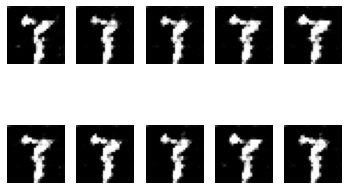

469/469 [==============================] - 25s 54ms/step - d_loss: 0.3119 - g_loss: 2.2514
Epoch 2/101
469/469 [==============================] - 24s 51ms/step - d_loss: 0.3518 - g_loss: 2.0475
Epoch 3/101
469/469 [==============================] - 25s 53ms/step - d_loss: 0.2927 - g_loss: 2.4391
Epoch 4/101
469/469 [==============================] - 25s 53ms/step - d_loss: 0.2973 - g_loss: 2.3511
Epoch 5/101
469/469 [==============================] - 24s 52ms/step - d_loss: 0.3319 - g_loss: 2.2219
Epoch 6/101
469/469 [==============================] - 24s 52ms/step - d_loss: 0.3942 - g_loss: 1.8588
Epoch 7/101
469/469 [==============================] - 24s 52ms/step - d_loss: 0.4189 - g_loss: 1.6801
Epoch 8/101
469/469 [==============================] - 25s 53ms/step - d_loss: 0.4394 - g_loss: 1.5888
Epoch 9/101
469/469 [==============================] - 24s 52ms/step - d_loss: 0.4381 - g_loss: 1.5771
Epoch 10/101
469/469 [==============================] - 24s 52ms/step - d_loss: 0.429

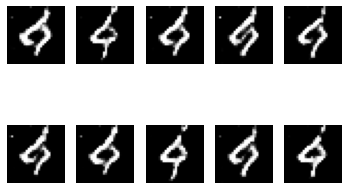

469/469 [==============================] - 25s 53ms/step - d_loss: 0.4162 - g_loss: 1.6683
Epoch 12/101
469/469 [==============================] - 24s 52ms/step - d_loss: 0.4049 - g_loss: 1.7267
Epoch 13/101
469/469 [==============================] - 25s 53ms/step - d_loss: 0.3969 - g_loss: 1.7830
Epoch 14/101
469/469 [==============================] - 24s 52ms/step - d_loss: 0.3912 - g_loss: 1.8170
Epoch 15/101
469/469 [==============================] - 24s 52ms/step - d_loss: 0.3943 - g_loss: 1.8290
Epoch 16/101
469/469 [==============================] - 24s 52ms/step - d_loss: 0.3931 - g_loss: 1.8323
Epoch 17/101
469/469 [==============================] - 24s 52ms/step - d_loss: 0.4033 - g_loss: 1.8005
Epoch 18/101
469/469 [==============================] - 24s 52ms/step - d_loss: 0.4124 - g_loss: 1.7327
Epoch 19/101
469/469 [==============================] - 25s 53ms/step - d_loss: 0.4191 - g_loss: 1.7007
Epoch 20/101
469/469 [==============================] - 24s 52ms/step - d_los

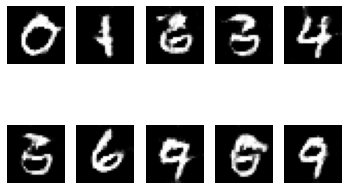

469/469 [==============================] - 26s 55ms/step - d_loss: 0.4339 - g_loss: 1.6045
Epoch 22/101
469/469 [==============================] - 25s 53ms/step - d_loss: 0.4375 - g_loss: 1.5899
Epoch 23/101
469/469 [==============================] - 24s 52ms/step - d_loss: 0.4402 - g_loss: 1.5680
Epoch 24/101
469/469 [==============================] - 24s 51ms/step - d_loss: 0.4420 - g_loss: 1.5482
Epoch 25/101
469/469 [==============================] - 24s 52ms/step - d_loss: 0.4425 - g_loss: 1.5316
Epoch 26/101
469/469 [==============================] - 25s 53ms/step - d_loss: 0.4438 - g_loss: 1.5290
Epoch 27/101
469/469 [==============================] - 29s 62ms/step - d_loss: 0.4389 - g_loss: 1.5314
Epoch 28/101
469/469 [==============================] - 38s 81ms/step - d_loss: 0.4394 - g_loss: 1.5370
Epoch 29/101
469/469 [==============================] - 42s 90ms/step - d_loss: 0.4333 - g_loss: 1.53480s - d_loss: 0
Epoch 30/101
469/469 [==============================] - 42s 90m

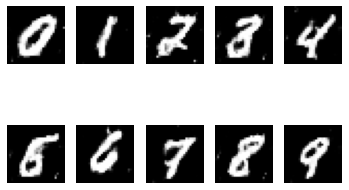

469/469 [==============================] - 46s 99ms/step - d_loss: 0.4231 - g_loss: 1.5827
Epoch 32/101
469/469 [==============================] - 50s 108ms/step - d_loss: 0.4189 - g_loss: 1.5938
Epoch 33/101
469/469 [==============================] - 51s 108ms/step - d_loss: 0.4126 - g_loss: 1.6237
Epoch 34/101
469/469 [==============================] - 49s 103ms/step - d_loss: 0.4078 - g_loss: 1.6343
Epoch 35/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.4061 - g_loss: 1.6636
Epoch 36/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.3983 - g_loss: 1.6799
Epoch 37/101
469/469 [==============================] - 50s 106ms/step - d_loss: 0.3911 - g_loss: 1.7027
Epoch 38/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.3914 - g_loss: 1.7161
Epoch 39/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.3858 - g_loss: 1.7404
Epoch 40/101
469/469 [==============================] - 50s 107ms/ste

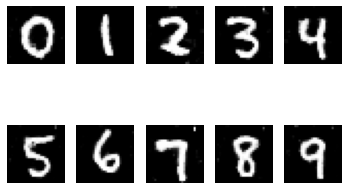

469/469 [==============================] - 51s 109ms/step - d_loss: 0.3773 - g_loss: 1.7798
Epoch 42/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.3715 - g_loss: 1.7944
Epoch 43/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.3705 - g_loss: 1.8160
Epoch 44/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.3614 - g_loss: 1.8401
Epoch 45/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.3607 - g_loss: 1.8574
Epoch 46/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.3551 - g_loss: 1.8631
Epoch 47/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.3570 - g_loss: 1.8843
Epoch 48/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.3530 - g_loss: 1.9181
Epoch 49/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.3442 - g_loss: 1.9276
Epoch 50/101
469/469 [==============================] - 50s 107ms/st

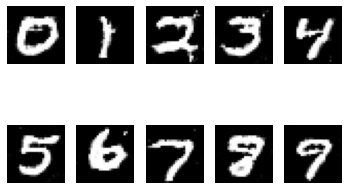

469/469 [==============================] - 51s 109ms/step - d_loss: 0.3443 - g_loss: 1.9575
Epoch 52/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.3423 - g_loss: 1.9714
Epoch 53/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.3378 - g_loss: 1.9811
Epoch 54/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.3326 - g_loss: 2.0189
Epoch 55/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.3308 - g_loss: 2.0381
Epoch 56/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.3264 - g_loss: 2.0376
Epoch 57/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.3274 - g_loss: 2.0648
Epoch 58/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.3239 - g_loss: 2.0758
Epoch 59/101
469/469 [==============================] - 50s 108ms/step - d_loss: 0.3193 - g_loss: 2.0895
Epoch 60/101
469/469 [==============================] - 50s 106ms/st

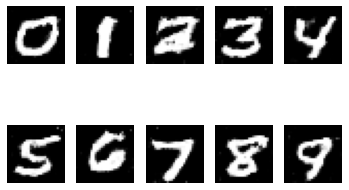

469/469 [==============================] - 51s 109ms/step - d_loss: 0.3177 - g_loss: 2.1106
Epoch 62/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.3225 - g_loss: 2.0956
Epoch 63/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.3312 - g_loss: 2.0584
Epoch 64/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.3309 - g_loss: 2.0453
Epoch 65/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.3475 - g_loss: 1.9856
Epoch 66/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.3581 - g_loss: 1.9231
Epoch 67/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.3657 - g_loss: 1.8739
Epoch 68/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.3715 - g_loss: 1.8558
Epoch 69/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.3836 - g_loss: 1.8074
Epoch 70/101
469/469 [==============================] - 50s 107ms/st

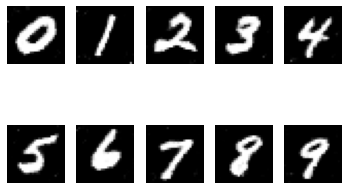

469/469 [==============================] - 51s 109ms/step - d_loss: 0.3960 - g_loss: 1.7375
Epoch 72/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.4081 - g_loss: 1.6843
Epoch 73/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.4169 - g_loss: 1.6433
Epoch 74/101
469/469 [==============================] - 50s 106ms/step - d_loss: 0.4306 - g_loss: 1.5846
Epoch 75/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.4414 - g_loss: 1.5381
Epoch 76/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.4531 - g_loss: 1.4977
Epoch 77/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.4667 - g_loss: 1.4436
Epoch 78/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.4779 - g_loss: 1.3954
Epoch 79/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.4899 - g_loss: 1.3478
Epoch 80/101
469/469 [==============================] - 50s 107ms/st

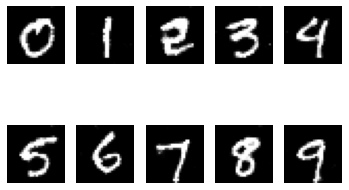

469/469 [==============================] - 51s 109ms/step - d_loss: 0.5110 - g_loss: 1.2756
Epoch 82/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.5210 - g_loss: 1.2382
Epoch 83/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.5317 - g_loss: 1.2107
Epoch 84/101
469/469 [==============================] - 50s 106ms/step - d_loss: 0.5423 - g_loss: 1.1707
Epoch 85/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.5568 - g_loss: 1.1324
Epoch 86/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.5672 - g_loss: 1.1003
Epoch 87/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.5763 - g_loss: 1.0698
Epoch 88/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.5827 - g_loss: 1.0491
Epoch 89/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.5905 - g_loss: 1.0306
Epoch 90/101
469/469 [==============================] - 50s 107ms/st

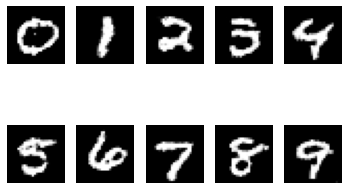

469/469 [==============================] - 51s 109ms/step - d_loss: 0.5968 - g_loss: 1.0085
Epoch 92/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.5995 - g_loss: 0.9996
Epoch 93/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.6018 - g_loss: 0.9931
Epoch 94/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.6001 - g_loss: 0.9968
Epoch 95/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.6005 - g_loss: 0.9949
Epoch 96/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.6009 - g_loss: 0.9947
Epoch 97/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.6018 - g_loss: 0.9932
Epoch 98/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.6026 - g_loss: 0.9900
Epoch 99/101
469/469 [==============================] - 50s 107ms/step - d_loss: 0.6021 - g_loss: 0.9904
Epoch 100/101
469/469 [==============================] - 50s 106ms/s

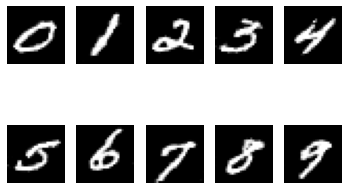

469/469 [==============================] - 51s 109ms/step - d_loss: 0.6040 - g_loss: 0.9908


In [9]:
gan.fit(train_X, train_y,
       epochs=101,
       shuffle=True,
       callbacks=[PlotCallback()],
       batch_size=128)